# Gaussian Process in PyMC4

### Theory

Gaussian process are non-parametric models that define a distribution over a function where function itself is a random variable of some inputs $X$. They can be thought of as a distribution over infinite dimensions but computation can be done using finite resources. This property makes them useful for many spacial and temporal prediction tasks. A Gaussian Process prior is parameterized by a mean function and a covariance function. Given these parameters, a GP prior can be defined as

$$f(x) \sim \mathcal{GP}\left(\mu(x), k(x, x')\right)$$

Given a prior and some new data $X^\prime$, the conditional $P(f(X^\prime) | f(X))$ can be evaluated as

$$P(f(X^\prime) | f(X)) = \frac{P(f(X^\prime), f(X))}{P(f(X))}$$

This conditional can then be used to sample new points from the inferred function.

### Implementation

The implementation of Gaussian Process model is divided in three parts:

1. Creating a mean function.
2. Creating a covariance function.
3. Creating a GP Model.

The following tutorial shows how to create a GP Model in PyMC4 step-by-step

In [1]:
# Importing our libraries
import sys
# print(sys.path)
sys.path.append("C:\\Users\\tirth\\Desktop\\INTERESTS\\PyMC4")
import pymc4 as pm
import numpy as np
import arviz as az

### Mean functions

The mean functions in PyMC4 are implemented using the following base class

```python
class Mean:
    r"""Base Class for all the mean functions in GP."""

    def __init__(self, feature_ndims=1):
        self.feature_ndims = feature_ndims

    def __call__(self, X):
        raise NotImplementedError("Your mean function should override this method")

    def __add__(self, mean2):
        return MeanAdd(self, mean2)

    def __mul__(self, mean2):
        return MeanProd(self, mean2)
```

where `feature_ndims` are the rightmost dimentions of the input that will be absorbed during the computation. The `__call__` method is used to evaluate the mean function at some point $X$. The $X$ (input) can be a TensorFlow Tensor or a NumPy array. PyMC4 allows addition (or multiplication) of two mean function to yield a new mean function that is an instance of ``MeanAdd`` (or ``MeanProd``). You can create your own mean function just by inheriting the base class and implementing the method ``__call__``.

The most common mean function used in GP models is the zero mean function that returns zero irrespective of the inputs. It can be implemented as

In [2]:
mean_fn = pm.gp.mean.Zero(feature_ndims=2)

### Covariance Functions

Covariance function try to approximate the covariance matrix of the modelled function. The base class used to implement covariance functions in PyMC4 is given below

```python
class Covariance:
    r"""Base class of all Covariance functions for Gaussian Process"""

    def __init__(self, feature_ndims, diag=False, **kwargs):
        self.feature_ndims = feature_ndims
        self.diag = diag
        self._kernel = self._init_kernel(feature_ndims=self.feature_ndims, **kwargs)

    @abstractmethod
    def _init_kernel(self, feature_ndims, **kwargs):
        raise NotImplementedError("Your Covariance class should override this method")

    def __call__(self, X1, X2, **kwargs):
        if self.diag:
            return tf.linalg.diag_part(self._kernel.apply(X1, X2, **kwargs))
        else:
            return self._kernel.matrix(X1, X2, **kwargs)

    def evaluate_kernel(self, X1, X2, **kwargs):
        ...

    def __add__(self, cov2):
        return CovarianceAdd(self, cov2)

    def __mul__(self, cov2):
        return CovarianceProd(self, cov2)
```

where ``_init_kernel`` is a method used to initialize the covariance function. This method should return a instance of covariance function that has ``matrix`` method to evaluate the covariance function and return a covariance matrix. Specifically, this method takes as input two tensors (or numpy arrays) of shape ``(batch_shape, n, features)`` and ``(batch_shape, m, features)`` and returns a covariance matrix of shape ``(batch_shape, n, m)``. This marix **must** be positive semi-definite. Meaning, $|C| > 0$ and $C = C^T$ where $C$ is the returned covariance matrix. You can optionally override ``evaluate_kernel`` method to evaluate the function at two specific points.

There are many covariance functions that can be used to infer different functions but the most common one is the Radial Basis Function. This function can be implemented using the ``ExpQuad`` covariance function in PyMC4.

$$k(x, x') = \sigma^2 \mathrm{exp}\left[ -\frac{(x - x')^2}{2 l^2} \right]$$

where $\sigma$ = ``amplitude`` and $l$ = ``length_scale`` i.e. the inputs that RBF kernel in PyMC4 takes.

In [3]:
cov_fn = pm.gp.cov.ExpQuad(amplitude=1., length_scale=1., feature_ndims=2)

### Latent Gaussian Process

The `gp.LatentGP` class is a direct implementation of a GP.  No additive noise is assumed.  It is called "Latent" because the underlying function values are treated as latent variables.  It has a `prior` method and a `conditional` method.  Given a mean and covariance function the function $f(x)$ is modeled as,
    
$$f(x) \sim \mathcal{GP}\left(\mu(x), k(x, x')\right)$$

Use the `prior` and `conditional` methods to actually construct random variables representing the unknown, or latent, function whose distribution is the GP prior or GP conditional.  This GP implementation can be used to implement regression on data that is not normally distributed. For more information on the `prior` and `conditional` methods, see their docstrings.

In [4]:
gp = pm.gp.gp.LatentGP(mean_fn, cov_fn)

### Sampling

Having defined the mean function, covariance function and the GP model, `prior` and `conditional` methods can be used to sample new points from the prior and conditional respectively by creating a `pm.model`.

In [5]:
@pm.model
def gpmodel(gp, X, Xnew):
    # Define a prior
    f = yield gp.prior('f', X)
    # Define a conditional oven new data points. Unlike PyMC3, the
    # `given` dictionary is NOT optional.
    cond = yield gp.conditional('cond', Xnew, given={'X': X, 'f': f})
    return cond

### Inputs to the GP model

Now, we are left with creating the inputs for our GP model. We will create random inputs `X` and `Xnew` with ``batch_shape=(2, 2)``, ``num_samples=10`` and ``feature_ndims=2`` of shape ``(2, 2)``.

In [6]:
# The leftmost (2, 2) is the batch_shape. In the middle are the
# actual data points and rightmost (2, 2) are the feature_ndims
# that are going to be absorbed during the computation.
X = np.random.randn(2, 2, 10, 2, 2)
# Create new data points with 5 samples
Xnew = np.random.randn(2, 2, 5, 2, 2)

# We can now create a final function from which we can sample
gp_model = gpmodel(gp, X, Xnew)

In [7]:
samples = pm.sample(gp_model, num_samples=100, num_chains=3)

Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.


In [8]:
print(samples.posterior)
print(samples.posterior["gpmodel/f"].shape)
print(samples.posterior["gpmodel/cond"].shape)

<xarray.Dataset>
Dimensions:             (chain: 3, draw: 100, gpmodel/cond_dim_0: 2, gpmodel/cond_dim_1: 2, gpmodel/cond_dim_2: 5, gpmodel/f_dim_0: 2, gpmodel/f_dim_1: 2, gpmodel/f_dim_2: 10)
Coordinates:
  * chain               (chain) int32 0 1 2
  * draw                (draw) int32 0 1 2 3 4 5 6 7 ... 92 93 94 95 96 97 98 99
  * gpmodel/f_dim_0     (gpmodel/f_dim_0) int32 0 1
  * gpmodel/f_dim_1     (gpmodel/f_dim_1) int32 0 1
  * gpmodel/f_dim_2     (gpmodel/f_dim_2) int32 0 1 2 3 4 5 6 7 8 9
  * gpmodel/cond_dim_0  (gpmodel/cond_dim_0) int32 0 1
  * gpmodel/cond_dim_1  (gpmodel/cond_dim_1) int32 0 1
  * gpmodel/cond_dim_2  (gpmodel/cond_dim_2) int32 0 1 2 3 4
Data variables:
    gpmodel/f           (chain, draw, gpmodel/f_dim_0, gpmodel/f_dim_1, gpmodel/f_dim_2) float32 -0.7852358 ... 0.027833257
    gpmodel/cond        (chain, draw, gpmodel/cond_dim_0, gpmodel/cond_dim_1, gpmodel/cond_dim_2) float32 0.23532183 ... -0.15818706
Attributes:
    created_at:  2020-03-03T17:17:35.1914

### Example 1 : Regression with Student-T distributed noise

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

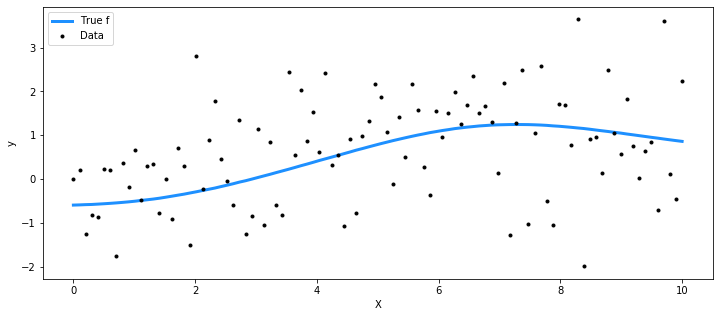

In [10]:
# set the seed
np.random.seed(None)

n = 100 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector
n_new = 200
X_new = np.linspace(0, 15, n_new)[:,None]

# Define the true covariance function and its parameters
l_true = 3.
cov_func = pm.gp.cov.ExpQuad(amplitude=1., length_scale=l_true, feature_ndims=1)

# A mean function that is zero everywhere
mean_func = pm.gp.mean.Zero()

# The latent function values are one sample from a multivariate normal
f_true = np.random.multivariate_normal(mean_func(X).numpy(), 
                                       cov_func(X, X).numpy() + 1e-6*np.eye(n), 1).flatten()

# The observed data is the latent function plus a small amount of T distributed noise
# The standard deviation of the noise is `sigma`, and the degrees of freedom is `nu`
# σ_true = 2.0
ν_true = 10.0
y = f_true + np.random.standard_t(ν_true, size=n)

## Plot the data and the unobserved latent function
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f")
ax.plot(X, y, 'ok', ms=3, label="Data")
ax.set_xlabel("X"); ax.set_ylabel("y"); plt.legend()

In [11]:
@pm.model
def latent_gp_model(X, y, X_new):
    l = yield pm.HalfCauchy("l", scale=5.)
    cov_fn = pm.gp.cov.ExpQuad(length_scale=l, amplitude=1., feature_ndims=1)
    latent_gp = pm.gp.gp.LatentGP(mean_fn=pm.gp.mean.Zero(), cov_fn=cov_fn)
    f = yield latent_gp.prior("f", X=X)
    f_pred = yield latent_gp.conditional("f_pred", X_new, given={'X': X, 'f': f})
    ν = yield pm.Gamma("ν", concentration=1., rate=0.1)
    y_ = yield pm.StudentT("y", loc=f, scale=1., df=ν, observed=y)
    return y_

In [12]:
gp = latent_gp_model(X, y, X_new)
trace = pm.sample(gp, num_samples=100, num_chains=1)

In [13]:
trace.posterior

<xarray.Dataset>
Dimensions:                       (chain: 1, draw: 100, latent_gp_model/f_dim_0: 100, latent_gp_model/f_pred_dim_0: 200)
Coordinates:
  * chain                         (chain) int32 0
  * draw                          (draw) int32 0 1 2 3 4 5 ... 94 95 96 97 98 99
  * latent_gp_model/f_dim_0       (latent_gp_model/f_dim_0) int32 0 1 ... 98 99
  * latent_gp_model/f_pred_dim_0  (latent_gp_model/f_pred_dim_0) int32 0 ... 199
Data variables:
    latent_gp_model/f             (chain, draw, latent_gp_model/f_dim_0) float32 0.05887174 ... 0.47653612
    latent_gp_model/f_pred        (chain, draw, latent_gp_model/f_pred_dim_0) float32 0.06264647 ... -0.1005566
    latent_gp_model/__log_l       (chain, draw) float32 0.6238997 ... 0.69333637
    latent_gp_model/__log_ν       (chain, draw) float32 2.41142 ... 2.1812391
    latent_gp_model/l             (chain, draw) float32 1.8661915 ... 2.0003784
    latent_gp_model/ν             (chain, draw) float32 11.149784 ... 8.857275
Attributes:
    created_at:  2020-03-03T17:20:28.069736

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DC77EFF748>,
      dtype=object)

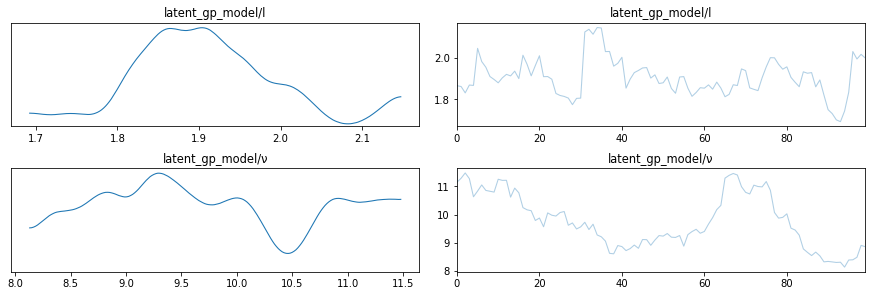

In [14]:
lines = [
    ("l", {}, l_true),
    ("ν", {}, ν_true),
]
az.plot_trace(trace, lines=lines, var_names=["latent_gp_model/l", "latent_gp_model/ν"])

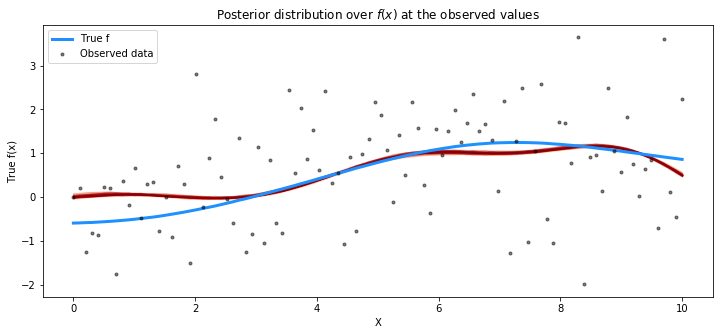

In [15]:
from pymc4.gp.util import plot_gp_dist
# plot the results
fig = plt.figure(figsize=(12,5)); ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
plot_gp_dist(ax, np.array(trace.posterior["latent_gp_model/f"])[0], X)

# plot the data and the true latent function
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data")

# axis labels and title
plt.xlabel("X"); plt.ylabel("True f(x)")
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend()

In [16]:
pred_samples = pm.sample_posterior_predictive(gp, trace=trace, var_names=["latent_gp_model/f_pred"])

In [17]:
pred_samples.posterior_predictive

<xarray.Dataset>
Dimensions:                       (chain: 1, draw: 100, latent_gp_model/f_pred_dim_0: 200)
Coordinates:
  * chain                         (chain) int32 0
  * draw                          (draw) int32 0 1 2 3 4 5 ... 94 95 96 97 98 99
  * latent_gp_model/f_pred_dim_0  (latent_gp_model/f_pred_dim_0) int32 0 ... 199
Data variables:
    latent_gp_model/f_pred        (chain, draw, latent_gp_model/f_pred_dim_0) float32 0.06264647 ... -0.1005566
Attributes:
    created_at:  2020-03-03T17:20:31.212333

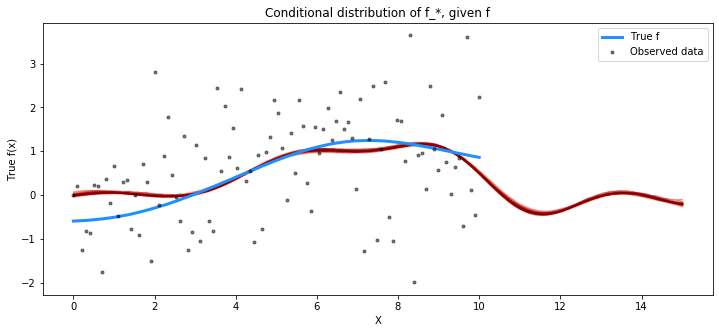

In [18]:
fig = plt.figure(figsize=(12,5)); ax = fig.gca()
plot_gp_dist(ax, pred_samples.posterior_predictive["latent_gp_model/f_pred"][0], X_new)
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f")
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data")
plt.xlabel("X"); plt.ylabel("True f(x)")
plt.title("Conditional distribution of f_*, given f"); plt.legend()